# Deep Neural Network to classify images with Pikachu

We will be building a deep neural network to implement image classification. We will use images of pikachu vs non-pikachu for classfication.

First let us load the packages.

In [25]:
import numpy as np
from PIL import Image
import os
from sklearn.model_selection import train_test_split # for train-test partition
import matplotlib.pyplot as plt
from IPython.display import display
from activations import *
from dnn_functions import *

%matplotlib inline

SyntaxError: invalid syntax (dnn_functions.py, line 41)

## Dataset

Now let us load the dataset. 

Images of pikachu were download from the internet (for some of the GIFs downloaded, all their frames were extracted, which will be less helpful in training, but there are only a few, and hopefully much less similar will turn up in our training sample). All pictures of Pikachu were converted to 256 X 256 JPEG files (3 channels) (some cropping required) using IrfanView.

For images of pokemon, I downloaded the [Pokemon Images Dataset](https://www.kaggle.com/kvpratama/pokemon-images-dataset "Pokemon Images Dataset | Kaggle") from Kaggle, and randomly selected 150 of them. 


In [3]:
# read images of pikachu and other pokemon

# first read pikachu images [186]
path = "d:/PData/image-recognition/images/"    
filelist = os.listdir(path+'positive/')
pikachu_orig = np.array([np.array(Image.open(path+'positive/'+fname)) for fname in filelist])

# now read non-pikachu images [150]
filelist = os.listdir(path+'negative/')
pokemon_orig = np.array([np.array(Image.open(path+'negative/'+fname)) for fname in filelist])

Let us look at some of the images here:

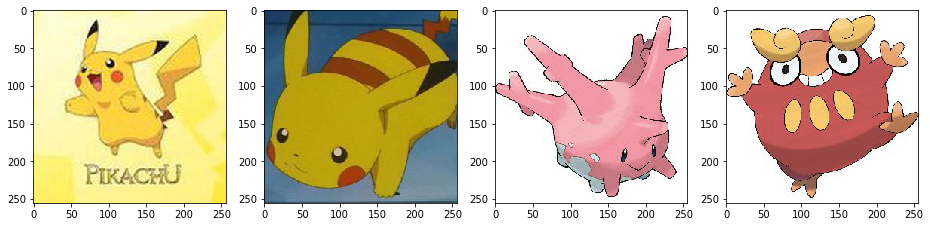

In [8]:
plt.figure(figsize=(20,10))

for i,image in enumerate([10,20]):
    plt.subplot(1,5,i+1)
    plt.imshow(pikachu_orig[i])
for i,image in enumerate([10,20]):
    plt.subplot(1,5,i+3)
    plt.imshow(pokemon_orig[i])


This is the kind of images we have. Now let us do some data modification.
We will first reshape/flatten the data into vectors and create a 2D matrix containing all images.

In [13]:
# Unpacking each image into a vector
pikachu = pikachu_orig.reshape(pikachu_orig.shape[0],-1)
pokemon = pokemon_orig.reshape(pokemon_orig.shape[0],-1)

print("Dimension of Pikachu matrix are: " + str(pikachu.shape))
print("Dimension of Pokemon matrix are: " + str(pokemon.shape))


Dimension of pikachu matrix are: (186, 196608)
Dimension of pikachu matrix are: (150, 196608)


Now to combine the two datasets and standardise/normalise the data (by dividing by 255)

In [15]:
fullset = np.concatenate((pikachu,pokemon),axis = 0)
fullset = fullset/255

Now let us create labels for the images. We will create a vector y, that will hold 0 if the image is pikachu and 1 if not.

In [22]:
# create label 1 for Pikachu, 0 for non-pikachu
labels = np.concatenate((np.zeros(pikachu.shape[0],int),np.ones(pokemon.shape[0],int)))
labels = labels.reshape(fullset.shape[0],1)


Finally we will partition data into train/validation/test sets using 60:20:20 split. We will also transpose the matrices so that each column is one image, and the m training examples are all column vectors.


In [23]:
# partition data into training, validation and test set
x_train,x_test,y_train,y_test = train_test_split(fullset,labels,test_size = 0.4)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)

x_train,x_val,x_test,y_train,y_val,y_test = x_train.T,x_val.T,x_test.T,y_train.T,y_val.T,y_test.T

print("Dimensions of Training set are:" + str(x_train.shape))
print("No of pikachu images in training set:" + str(np.sum(y_train)))

print("\n")

print("Dimensions of Test set are:" + str(x_test.shape))
print("No of pikachu images in test set:" + str(np.sum(y_test)))

Dimensions of Training set are:(196608, 201)
No of pikachu images in training set:92


Dimensions of Test set are:(196608, 67)
No of pikachu images in test set:27


Model Building
---------------

We will be building a 5 layer neural network.

The general methodology will be:

1. Initialise parameters (W,b,n_h[l])
2. Loop for no_iterations : 

    a.  Forward pass which will compute Y-hat (AL) by going through all the layers. 
        - In each layer l we do the following: A[l] = g[l]Z[l]; Z[l] = W.A[l-1] + b
    b. Compute Cost
    
    c. Backward propagation - compute gradients
        - dZ[l] = dA[l] * g[l]'(Z[l])
        - dW[l] = 1/m dZ[l]*A[l].T
        - db[l] = 1/m np.sum(dZ[l],axis = 1, keepdims = True)
        - dA[l-1]= W[l]T . dZ[l]
        - starts with dA[l] = (-Y/AL + (1-Y)/(1-AL) )
    d.Update parameters using gradients from the backpass
3. Use trained paramaeters to predict model    


For the activations we will use Relu for the first L-1 layers, and sigmoid for the last layer. So the architecture of the model is:

Input --> Linear->ReLU $\times$(L-1)  --> Linear-> Sigmoid

Now to finally implement the model using the functions built in `activation.py` and `dnn-functions.py`. 


In [21]:
# Layer parameters
layers_dims = [196608, 20, 7, 5, 1] #  4-layer model with first input the number of features and
                                    #  each subsequent value being the hidden units at each layer

In [ ]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False): 
    """
    Implements a L-layer neural network with the following arch: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, 256 * 256 * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    #np.random.seed(1)
    costs = []                         # store costs to plot cost with iterations
    
    # Parameters initialization
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters